[aihub]: https://durhamcollege.ca/wp-content/uploads/ai-hub-header.jpg "DC Logo"

![alt text][aihub]

# TensorFlow - Lesson #9
## Video Data

Built for use in the AI Hub at Durham College 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;by Amit Maraj  (amit.maraj@durhamcollge.ca)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&  Connlaoi Smith (connlaoi.smith@dcmail.ca)

Based on the original TensorFlow tutorials 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

<br/>
<hr/>
<br/>


## [Click here to follow along with the video on YouTube](https://www.youtube.com/watch?v=9sYBC2_AVfA&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ&t=0s&index=13)

<br/>

## <span style="color: #16a085">Introduction</span>

The previous Tutorial #08 showed how to use the pre-trained Inception model on the CIFAR-10 data-set in so-called Transfer Learning. This tutorial shows how to use your own images.

For demonstration, we use a new data-set called [Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony) that contains thousands of images of cutlery knives, spoons and forks on a few different backgrounds. The training-set contains 4170 images and the test-set contains 530 images. The classes are named knifey, spoony and forky as a reference to The Simpsons.

The images in the knifey-spoony data-set were created from video-files using a small Python [script](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py) that is run on Linux (it requires the `avconv`-program for conversion from videos to images). This allows you to easily create very large data-sets with thousands of images from just a few minutes of video recordings.

This tutorial builds on the previous tutorials so you should be familiar with Tutorial #08 on Transfer Learning, as well as earlier tutorials on how to build and train Neural Networks in TensorFlow.

## <span style="color: #16a085">Flowchart</span>

The following chart shows how the data flows when using the Inception model for Transfer Learning. First we input and process an image with the Inception model. Just prior to the final classification layer of the Inception model, we save the so-called Transfer Values to a cache-file.

This is very similar to how it was done in Tutorial #08, except that we now use the Knifey-Spoony data-set instead of CIFAR-10, which means that we are now feeding jpeg-images into the Inception model instead of numpy-arrays with image-data.

When all the images in the new data-set have been processed through the Inception model and the resulting transfer-values saved to a cache file, then we can use those transfer-values as the input to another neural network. We will then train the second neural network using the classes from the new data-set, so the network learns how to classify images based on the transfer-values from the Inception model.

In this way, the Inception model is used to extract useful information from the images and another neural network is then used for the actual classification.

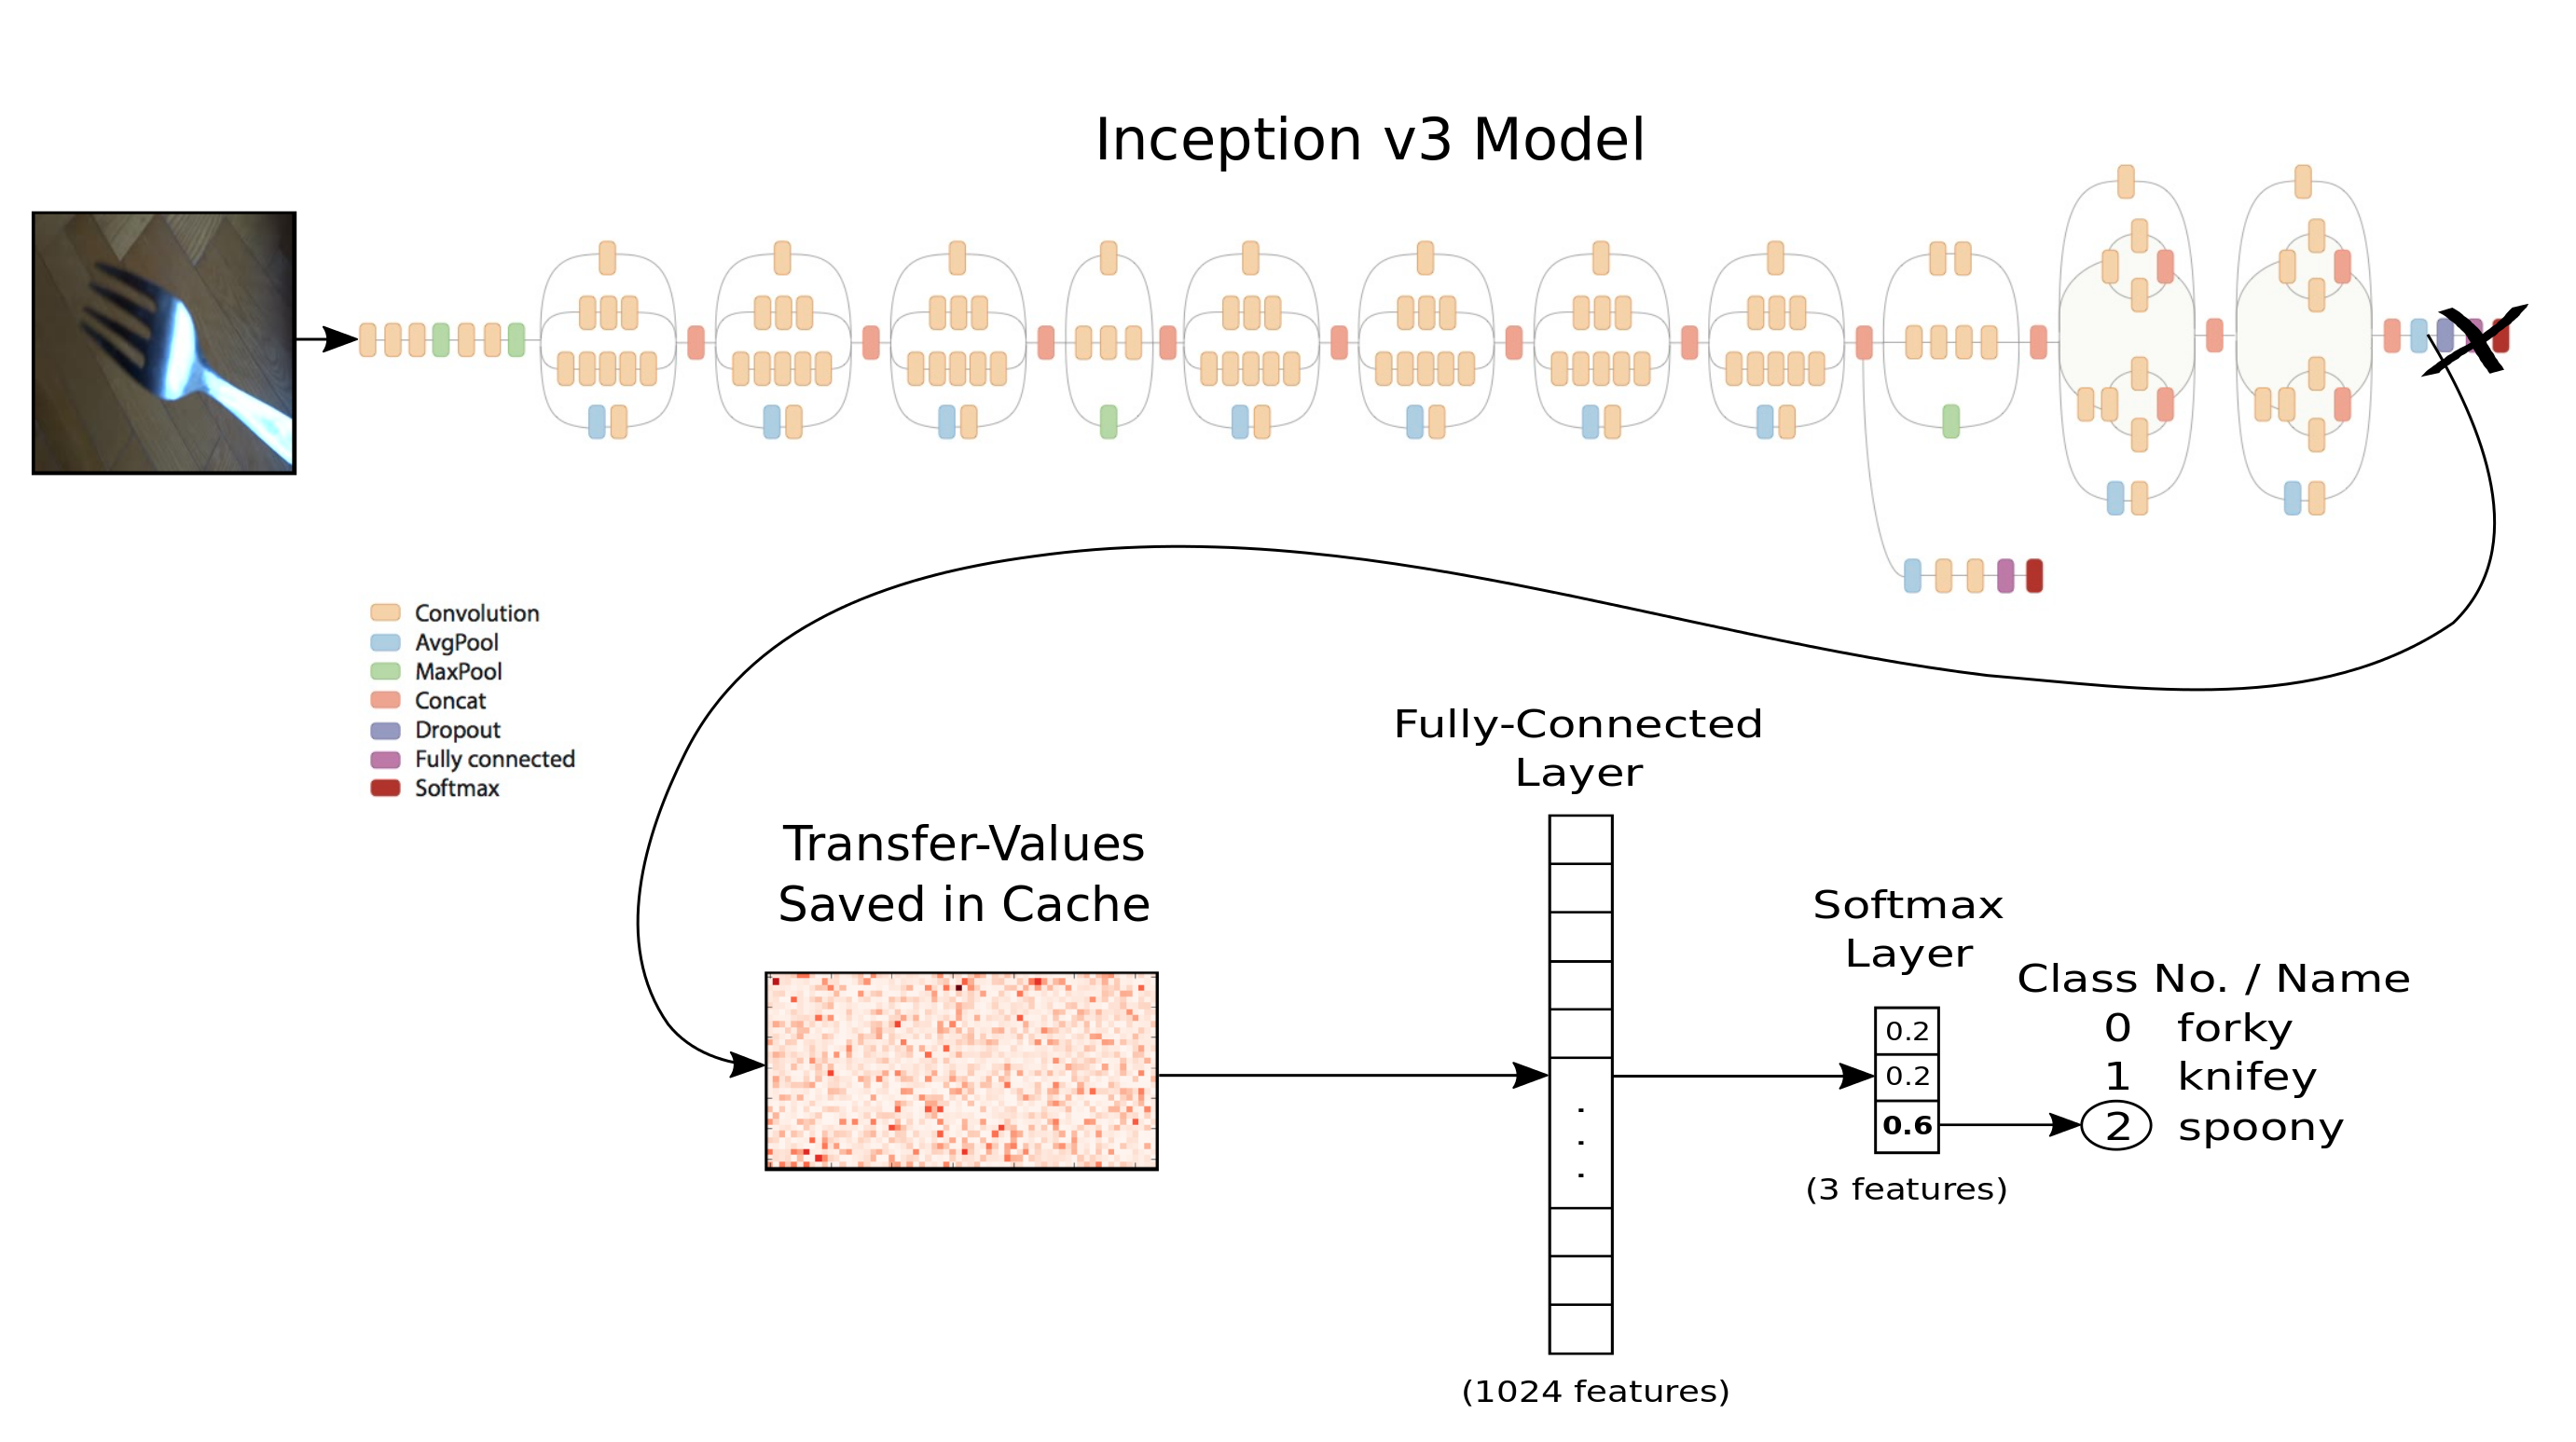

In [1]:
from IPython.display import Image, display
Image('data/images/09_transfer_learning_flowchart.png')

## <span style="color: #16a085">Imports</span>

We have removed a portion of redundant code in order to minimize the time it takes to read each lesson.

If you need to review it or make changes, it is in the data folder provided with these lessons.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
from data import inception

# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

C:\Users\Reasonable\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.6.0'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## <span style="color: #16a085">Load Data</span>

In [7]:
from data import knifey

The data dimensions have already been defined in the `knifey` module, so we just need to import the ones we need.

In [9]:
from data.knifey import num_classes

Set the directory for storing the data-set on your computer.

In [10]:
knifey.data_dir = "data/knifey-spoony/"

Set the directory that will be used for cache-files in this tutorial.

In [11]:
data_dir = knifey.data_dir

The Knifey-Spoony data-set is about 22 MB and will be downloaded automatically if it is not located in the given path.

In [12]:
knifey.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


Now load the data-set. This scans the sub-directories for all `*.jpg` images and puts the filenames into two lists for the training-set and test-set. This does not actually load the images, which will be done when the transfer-values are being calculated further below.

The lists of filenames are cached to harddisk so we can be sure that they are ordered in the same way when reloading the data-set later. This is important so we know which image-file corresponds to which transfer-values.

In [13]:
dataset = knifey.load()

Creating dataset from the files in: data/knifey-spoony/
- Data saved to cache-file: data/knifey-spoony/knifey-spoony.pkl


### <span style="color: #16a085">Your Data</span>

You can use your own images instead of loading the knifey-spoony data-set. You have to create a `DataSet`-object from the `dataset.py` module. The best way is to use the `load_cached()`-wrapper-function which automatically saves a cache-file with the lists of image-files, so you make sure that the ordering is consistent with the transfer-values created below.

The images must be organized in sub-directories for each of the classes. See the documentation in the `dataset.py` module for more details.

In [16]:
# This is the code you would run to load your own image-files.
# It has been commented out so it won't run now.

# from dataset import load_cached
#dataset = load_cached(cache_path='my_dataset_cache.pkl', in_dir='my_images/')
num_classes = dataset.num_classes

### <span style="color: #16a085">Training and Test-Sets</span> 

Get the class-names.

In [17]:
class_names = dataset.class_names
class_names

['forky', 'knifey', 'spoony']

Get the training-set. This returns the file-paths for the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [18]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

Print the first image-path to see if it looks OK.

In [19]:
image_paths_train[0]

'D:\\OneDrive\\Projects\\GitRepositories\\cooking-dough-with-tensorflow\\data\\knifey-spoony\\forky\\forky-01-0001.jpg'

Get the test-set.

In [20]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

Print the first image-path to see if it looks OK.

In [21]:
image_paths_test[0]

'D:\\OneDrive\\Projects\\GitRepositories\\cooking-dough-with-tensorflow\\data\\knifey-spoony\\forky\\test/forky-test-01-0001.jpg'

The Knifey-Spoony data-set has now been loaded and consists of 4700 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [22]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		4170
- Test-set:		530


### <span style="color: #16a085">Helper-function for plotting images</span>

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [23]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### <span style="color: #16a085">Helper-function for loading images</span> 

This data-set does not load the actual images, instead it has a list of the images in the training-set and another list for the images in the test-set. This helper-function loads some image-files.

In [24]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### <span style="color: #16a085">Plot a few images to see if data is correct</span>

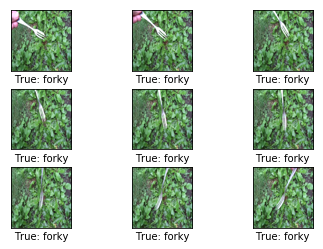

In [25]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

## <span style="color: #16a085">Download the Inception Model</span>

The Inception model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [27]:
inception.data_dir = 'data/inception/'

Download the data for the Inception model if it doesn't already exist in the directory. It is 85 MB.

See Tutorial #07 for more details.

In [28]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## <span style="color: #16a085">Load the Inception Model</span>

Load the Inception model so it is ready for classifying images.

Note the deprecation warning, which might cause the program to fail in the future.

In [29]:
model = inception.Inception()

## <span style="color: #16a085">Calculate Transfer-Values</span>

Import a helper-function for caching the transfer-values of the Inception model.

In [30]:
from data.inception import transfer_values_cache

Set the file-paths for the caches of the training-set and test-set.

In [31]:
file_path_cache_train = os.path.join(data_dir, 'inception-knifey-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-knifey-test.pkl')

In [32]:
print("Processing Inception transfer-values for training-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:   4170 / 4170
- Data saved to cache-file: data/knifey-spoony/inception-knifey-train.pkl


In [33]:
print("Processing Inception transfer-values for test-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:    530 / 530
- Data saved to cache-file: data/knifey-spoony/inception-knifey-test.pkl


Check the shape of the array with the transfer-values. There are 4170 images in the training-set and for each image there are 2048 transfer-values.

In [34]:
transfer_values_train.shape

(4170, 2048)

Similarly, there are 530 images in the test-set with 2048 transfer-values for each image.

In [35]:
transfer_values_test.shape

(530, 2048)

### <span style="color: #16a085">Helper-function for plotting transfer-values</span>

In [36]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


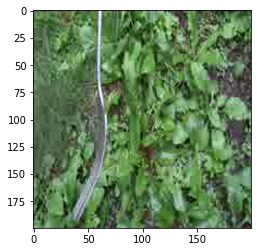

Transfer-values for the image using Inception model:


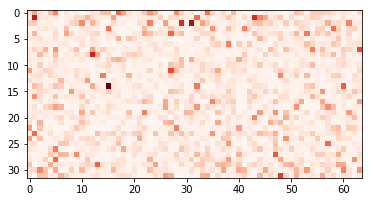

In [37]:
plot_transfer_values(i=100)

Input image:


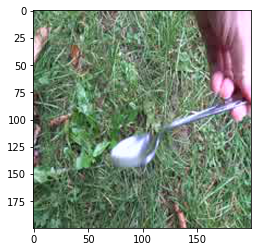

Transfer-values for the image using Inception model:


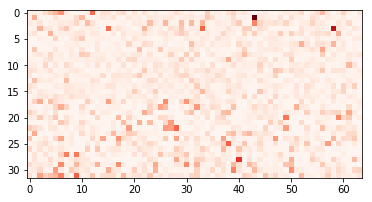

In [38]:
plot_transfer_values(i=300)

## <span style="color: #16a085">Analysis of Transfer-Values using PCA</span>

Use Principal Component Analysis (PCA) from scikit-learn to reduce the array-lengths of the transfer-values from 2048 to 2 so they can be plotted.

In [39]:
from sklearn.decomposition import PCA

Create a new PCA-object and set the target array-length to 2.

In [40]:
pca = PCA(n_components=2)

It takes a while to compute the PCA. In this case the data-set is not so large, but otherwise you could select a smaller part of the training-set to speed up the computation.

In [41]:
# transfer_values = transfer_values_train[0:3000]
transfer_values = transfer_values_train

Get the class-numbers for the samples you selected.

In [42]:
# cls = cls_train[0:3000]
cls = cls_train

Check that the array has 4170 samples and 2048 transfer-values for each sample.

In [43]:
transfer_values.shape

(4170, 2048)

Use PCA to reduce the transfer-value arrays from 2048 to 2 elements.

In [44]:
transfer_values_reduced = pca.fit_transform(transfer_values)

Check that it is now an array with 4170 samples and 2 values per sample.

In [45]:
transfer_values_reduced.shape

(4170, 2)

Helper-function for plotting the reduced transfer-values.

In [46]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Create an index with a random permutation to make a better plot.
    idx = np.random.permutation(len(values))
    
    # Get the color for each sample.
    colors = cmap[cls[idx]]

    # Extract the x- and y-values.
    x = values[idx, 0]
    y = values[idx, 1]

    # Plot it.
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

Plot the transfer-values that have been reduced using PCA. There are 3 different colors for the different classes in the Knifey-Spoony data-set. The colors have very large overlap. This may be because PCA cannot properly separate the transfer-values.

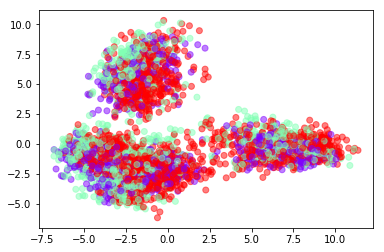

In [47]:
plot_scatter(transfer_values_reduced, cls=cls)

## <span style="color: #16a085">Analysis of Transfer-Values using t-SNE</span>

In [48]:
from sklearn.manifold import TSNE

Another method for doing dimensionality reduction is t-SNE. Unfortunately, t-SNE is very slow so we first use PCA to reduce the transfer-values from 2048 to 50 elements.

In [49]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

Create a new t-SNE object for the final dimensionality reduction and set the target to 2-dim.

In [50]:
tsne = TSNE(n_components=2)

Perform the final reduction using t-SNE. The current implemenation of t-SNE in scikit-learn cannot handle data with many samples so this might crash if you use the full training-set.

In [51]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

Check that it is now an array with 4170 samples and 2 transfer-values per sample.

In [52]:
transfer_values_reduced.shape

(4170, 2)

Plot the transfer-values that have been reduced to 2-dim using t-SNE, which shows better separation than the PCA-plot above.

This means the transfer-values from the Inception model appear to contain enough information to separate the Knifey-Spoony images into classes, although there is still some overlap so the separation is not perfect.

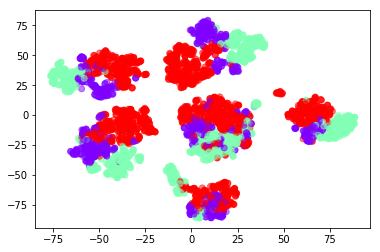

In [53]:
plot_scatter(transfer_values_reduced, cls=cls)

## <span style="color: #16a085">New Classifier in TensorFlow</span>

Now we will create another neural network in TensorFlow. This network will take as input the transfer-values from the Inception model and output the predicted classes for Knifey-Spoony images.

It is assumed that you are already familiar with how to build neural networks in TensorFlow, otherwise see e.g. Tutorial #03.

### <span style="color: #16a085">Placeholder Variables</span>

First we need the array-length for transfer-values which is stored as a variable in the object for the Inception model.

In [54]:
transfer_len = model.transfer_len

Now create a placeholder variable for inputting the transfer-values from the Inception model into the new network that we are building. The shape of this variable is `[None, transfer_len]` which means it takes an input array with an arbitrary number of samples as indicated by the keyword `None` and each sample has 2048 elements, equal to `transfer_len`.

In [55]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

Create another placeholder variable for inputting the true class-label of each image. These are so-called One-Hot encoded arrays with 3 elements, one for each possible class in the data-set.

In [56]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

Calculate the true class as an integer. This could also be a placeholder variable.

In [57]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### <span style="color: #16a085">Neural Network</span>

Create the neural network for doing the classification on the Knifey-Spoony data-set. This takes as input the transfer-values from the Inception model which will be fed into the placeholder variable `x`. The network outputs the predicted class in `y_pred`.

See Tutorial #03 for more details on how to use Pretty Tensor to construct neural networks.

In [58]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### <span style="color: #16a085">Optimization Method</span>

Create a variable for keeping track of the number of optimization iterations performed.

In [59]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Method for optimizing the new neural network.

In [60]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### <span style="color: #16a085">Classification Accuracy</span>

The output of the network `y_pred` is an array with 3 elements. The class number is the index of the largest element in the array.

In [61]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Create an array of booleans whether the predicted class equals the true class of each image.

In [62]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the array of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [63]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## <span style="color: #16a085">TensorFlow Run</span>

### <span style="color: #16a085">Create TensorFlow Session</span>

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [64]:
session = tf.Session()

### <span style="color: #16a085">Initialize Variables</span>

The variables for the new network must be initialized before we start optimizing them.

In [65]:
session.run(tf.global_variables_initializer())

### <span style="color: #16a085">Helper-function to get a random training-batch</span>

There are 4170 images (and arrays with transfer-values for the images) in the training-set. It takes a long time to calculate the gradient of the model using all these images (transfer-values). We therefore only use a small batch of images (transfer-values) in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [66]:
train_batch_size = 64

Function for selecting a random batch of transfer-values from the training-set.

In [67]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### <span style="color: #16a085">Helper-function to perform optimization</span>

This function performs a number of optimization iterations so as to gradually improve the variables of the neural network. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [68]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## <span style="color: #16a085">Helper-Functions for Showing Results</span>

### <span style="color: #16a085">Helper-function to plot example errors</span>

Function for plotting examples of images from the test-set that have been mis-classified.

In [69]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the indices for the incorrectly classified images.
    idx = np.flatnonzero(incorrect)

    # Number of images to select, max 9.
    n = min(len(idx), 9)
    
    # Randomize and select n indices.
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # Get the predicted classes for those images.
    cls_pred = cls_pred[idx]

    # Get the true classes for those images.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # Note: We cannot do image_paths_test[idx] on lists of strings.
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # Plot the images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

### <span style="color: #16a085">Helper-function to plot confusion matrix</span>

In [70]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### <span style="color: #16a085">Helper-functions for calculating classifications</span>

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [71]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [72]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### <span style="color: #16a085">Helper-functions for calculating the classification accuracy</span>

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [73]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### <span style="color: #16a085">Helper-function for showing the classification accuracy</span>

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [74]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## <span style="color: #16a085">Results</span>

## <span style="color: #16a085">Performance before any optimization</span>

The classification accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [76]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 52.6% (279 / 530)
Confusion Matrix:
[90  0 61] (0) forky
[91  0 46] (1) knifey
[ 53   0 189] (2) spoony
 (0) (1) (2)


## <span style="color: #16a085">Performance after 1000 optimization iterations</span>

After 1000 optimization iterations, the classification accuracy is about 70% on the test-set.

In [77]:
optimize(num_iterations=1000)

Global Step:    100, Training Batch Accuracy:  92.2%
Global Step:    200, Training Batch Accuracy:  98.4%
Global Step:    300, Training Batch Accuracy:  96.9%
Global Step:    400, Training Batch Accuracy:  98.4%
Global Step:    500, Training Batch Accuracy:  98.4%
Global Step:    600, Training Batch Accuracy: 100.0%
Global Step:    700, Training Batch Accuracy: 100.0%
Global Step:    800, Training Batch Accuracy: 100.0%
Global Step:    900, Training Batch Accuracy: 100.0%
Global Step:   1000, Training Batch Accuracy: 100.0%
Time usage: 0:00:04


Accuracy on Test-Set: 71.9% (381 / 530)
Example errors:


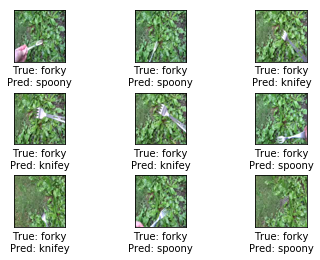

Confusion Matrix:
[41 48 62] (0) forky
[  7 105  25] (1) knifey
[  1   6 235] (2) spoony
 (0) (1) (2)


In [78]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## <span style="color: #16a085">Close TensorFlow Session</span>

We are now done using TensorFlow, so we close the session to release its resources. Note that we have two TensorFlow-sessions so we close both.

In [79]:
# This can be commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
model.close()
session.close()

## <span style="color: #16a085">Conclusion</span>

This tutorial showed how to use your own images in Transfer Learning with the Inception model. Thousands of images were used in this tutorial which were generated from just a few minutes of video recordings using a Python [script](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py).

However, the classification accuracy was not very good on the Knifey-Spoony data-set, especially for images of forks. The reason for this may be that the Inception model was originally trained on the ImageNet data-set which only contains 16 images of forks, while it contains more than 1200 images of spoons and more than 1300 images of knives. So it is possible that the Inception model cannot properly recognize forks.

We therefore need another technique for fine-tuning the Inception model so it becomes better at recognizing images of forks.

## <span style="color: #16a085">Exercises</span>

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try changing the neural network for doing the new classification. What happens if you remove the fully-connected layer, or add more fully-connected layers?
* What happens if you perform fewer or more optimization iterations?
* Try and delete some of the spoony-images in the training-set so there is a similar amount of images in each of the 3 classes (take a backup first). You also need to delete all the cache-files with `*.pkl` filenames and re-run this Notebook. Does this improve the classification accuracy? Compare the confusion matrix before and after this change.
* Create your own data-set using the `convert.py` script. For example, make video recordings of cars and motorcycles and build a classification system that can tell those two classes apart.
* Is it necessary to delete unclear images from the training-set you have created? What happens to the classification accuracy if you delete the unclear images?
* Make changes to this Notebook so you can input a single image instead of a whole data-set. You don't have to cache the transfer-values from the Inception model.
* Can you build a better or faster Neural Network for your data-set instead of using the Inception model with Transfer Learning?
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.